In [1]:
import jsonlines
from pathlib import Path
import uuid
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import os

In [2]:
paths = [x for x in Path("./files/").glob("**/*") if x.is_file() and x.suffix == ".jsonl"]

data = []

for path in paths:
    with jsonlines.open(path.resolve(), "r") as reader:
        data += reader.read()

In [3]:
title2id = {}  # {"paper_title": "id",...}
relations = []  # [[citing_id,intent,citation_id],...]
id2meta = {}  # {"id": {"title": "paper_title",...}}

In [4]:
counter = 0

rel_map = {"Background": 1, "Method": 2, "Result": 3}

for paper in data:
    paper_id = paper["paper_id"]
    paper_title = paper["paper_title"]
    affiliations = list(set([i[1] for i in paper["affiliations"]])) if "affiliations" in paper else []
    
    if paper_title == "":
        continue
    
    if paper_title not in title2id:
        title2id[paper_title] = paper_id
    else:
        paper_id = title2id[paper_title]
    
    id2meta[paper_id] = {"title": paper_title, "affiliations": affiliations}
    
    for citation in paper["citations"]:
        
        uid = str(uuid.uuid4())
        try:
            citation_title = citation["bib_item"]["title"]
            citation_year = citation["bib_item"]["year"]
            
            if citation_title == "":
                continue
        except:
            continue
        citation_intent = citation["intent"]
        
        if citation_title not in title2id:
            title2id[citation_title] = uid
        else:
            uid = title2id[citation_title]
                
        relations.append([paper_id, citation_intent, uid])
        
        if uid not in id2meta:
            id2meta[uid] = {"title": citation_title, "year": citation_year}
        else:
            id2meta[uid]["year"] = citation_year
        
#     break

In [5]:
len(title2id), len(relations), len(id2meta)

(266184, 404804, 266184)

In [6]:
def convert_id_relations_to_property_relations(relations, id2meta, prop1, prop2):
    triple = []
    
    for n1,r,n2 in relations:
        n1a = id2meta[n1][prop1] if prop1 in id2meta[n1] else None
        n2a = id2meta[n2][prop2] if prop2 in id2meta[n2] else None
        
        if n1a and n2a:
            if type(n1a) == list and type(n2a) == list:
                n1a = n1a[0]
                n2a = n2a[0]
            triple.append([n1a,r,n2a])
    return triple


def convert_id_relations_to_title_relations(relations, id2meta):
    title_relations = []
    
    for n1,r,n2 in relations:
        n1t = id2meta[n1]["title"]
        n2t = id2meta[n2]["title"]
        title_relations.append([n1t,r,n2t])
    
    return title_relations

In [7]:
year_relations = convert_id_relations_to_property_relations(relations, id2meta, "title", "year")
print(len(year_relations))
node_year_relations_df = pd.DataFrame(year_relations, columns=["node1", "relation", "node2"])
node_year_relations_df[:1000]

392418


,node1,relation,node2
0,viruses Current Trends in Diagnostics of Viral...,Background,2012
1,viruses Current Trends in Diagnostics of Viral...,Background,2008
2,viruses Current Trends in Diagnostics of Viral...,Background,2004
3,viruses Current Trends in Diagnostics of Viral...,Background,2020
4,viruses Current Trends in Diagnostics of Viral...,Background,2002
...,...,...,...
995,Health outcomes of tourism development: A long...,Background,2000
996,Health outcomes of tourism development: A long...,Background,2005
997,Health outcomes of tourism development: A long...,Background,1996
998,Health outcomes of tourism development: A long...,Background,1986


In [8]:
affiliation_relations = convert_id_relations_to_property_relations(relations, id2meta, "affiliations", "affiliations")
node_affiliation_relations_df = pd.DataFrame(affiliation_relations, columns=["node1", "relation", "node2"])
print(len(affiliation_relations))
node_affiliation_relations_df

648


,node1,relation,node2
0,Federal Service on Consumers' Rights Protectio...,Method,Tel-Aviv University
1,Federal Service on Consumers' Rights Protectio...,Method,Tel-Aviv University
2,Montpellier University Hospital,Background,Jiaotong University Health Science Center
3,University of Washington,Background,University of Amsterdam
4,Academia Sinica,Background,KU Leuven
...,...,...,...
643,Dhaka Sishu Hospital,Background,University of Ulsan College of Medicine
644,Dhaka Sishu Hospital,Background,University of Ulsan College of Medicine
645,The HKU-Pasteur Research Centre (HKU-PRC),Method,University of Siena
646,The HKU-Pasteur Research Centre (HKU-PRC),Method,University of Siena


In [9]:
title_relations = convert_id_relations_to_title_relations(relations, id2meta)
node_title_relations_df = pd.DataFrame(title_relations, columns=["node1", "relation", "node2"])
# relations via title
node_title_relations_df = node_title_relations_df.replace(":","", regex=True)

In [10]:
# relations via id
node_id_relations_df = pd.DataFrame(relations, columns=["node1", "relation", "node2"])

In [12]:
from py2neo import Graph, Node, Relationship

uri = "bolt://localhost:7687"
user = "neo4j"
password = "password"

g = Graph(uri=uri, user=user, password=password)

# optionally clear the graph
g.delete_all()

# begin a transaction
tx = g.begin()

# create list of affiliations
aff_list = list(set([j for i in [[a[0],a[-1]] for a in affiliation_relations] for j in i]))

# define nodes
for aff in aff_list:
    tx.create(Node("Affiliation", name=aff))

statement_1 = "MATCH (a {name:$A}), (b {name:$B}) CREATE (a)-[:Background]->(b)"
statement_2 = "MATCH (a {name:$A}), (b {name:$B}) CREATE (a)-[:Method]->(b)"
statement_3 = "MATCH (a {name:$A}), (b {name:$B}) CREATE (a)-[:Result]->(b)"

statement_map = {"Background": statement_1, "Method": statement_2, "Result": statement_3}

# define some nodes and relationships
for n1,r,n2 in affiliation_relations:
    tx.run(statement_map[r], {"A": n1, "B": n2})
    
# commit the transaction
tx.commit()

<Bookmark 'FB:kcwQ60hMPG2gTR+kl79u6+5lsk2Q'>

# Analysis of relations

### Most cited paper by year

In [15]:
node2_citations_sorted_df = pd.DataFrame(node_id_relations_df.node2.value_counts())

In [16]:
years = []

for _id in node_id_relations_df.node2.tolist():
    if "year" in id2meta[_id] and id2meta[_id]["year"]:
        year = id2meta[_id]["year"]
        years.append(year)
    else:
        years.append(np.nan)

node_id_relations_df["node2_year"] = years

pairs = []
year_counts = defaultdict(int)
list_of_years = list(range(1900,2021))

for _id in tqdm(node2_citations_sorted_df[:5000].index):
    if list_of_years == []:
        break
    if "year" in id2meta[_id] and id2meta[_id]["year"]:
        year = int(id2meta[_id]["year"])
    else: 
        continue
    if year in list_of_years:
        counts = node2_citations_sorted_df.loc[_id].node2
        pairs.append([year, counts])
        year_counts[year] += counts

In [17]:
df = pd.DataFrame([[k,v] for k,v in year_counts.items() if k > 1980], columns=["year", "count"]).sort_values("year")

### Years of papers being cited after 1980

<BarContainer object of 40 artists>

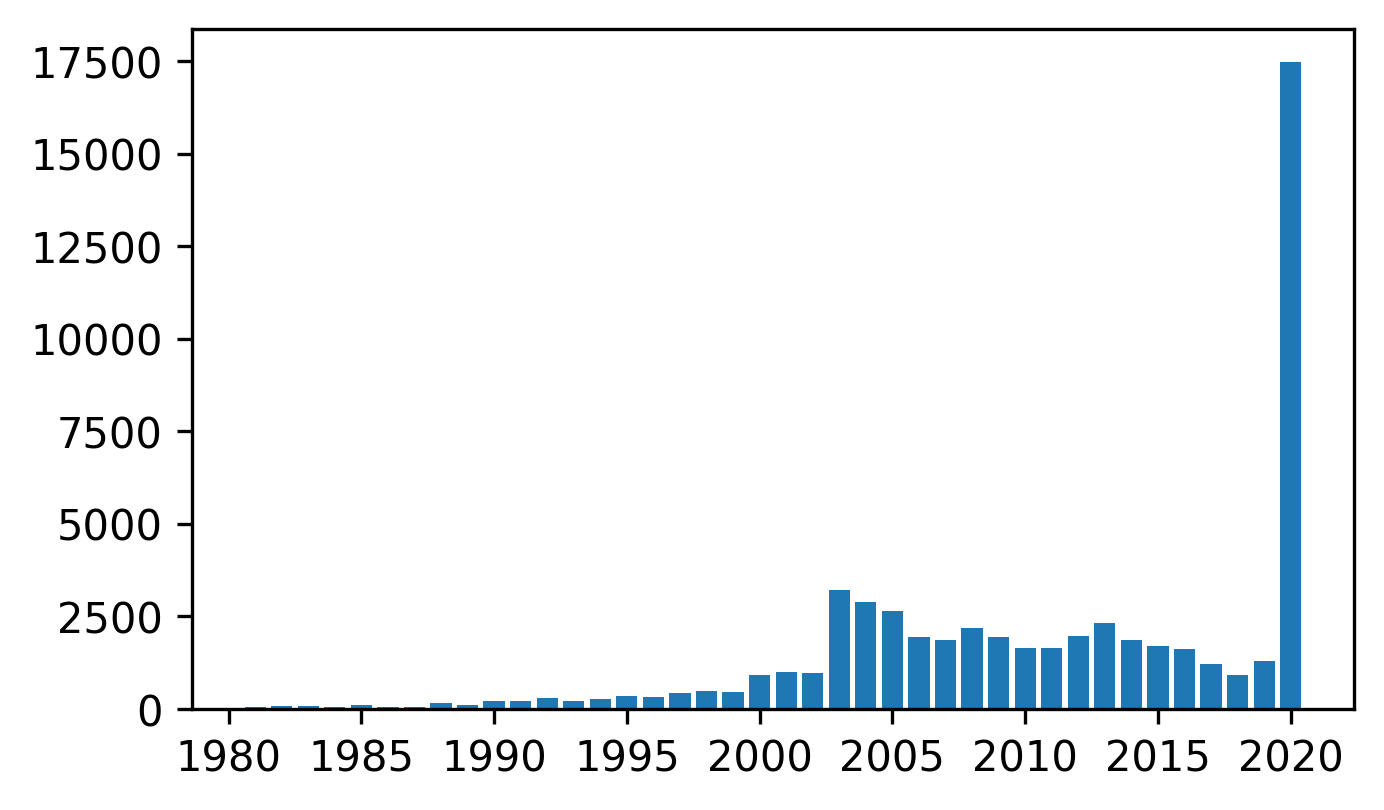

In [18]:
fig = plt.figure(figsize=(5,3), dpi=300)
plt.bar(df["year"].tolist(), df["count"].tolist())

### Years of papers being cited after 1980 by intent

In [19]:
paper_intent_counts = defaultdict()

for i in tqdm(node_id_relations_df.index):
    node1, rel, node2, _ = node_id_relations_df.iloc[i]
    if node2 in paper_intent_counts:
        paper_intent_counts[node2][rel] = paper_intent_counts[node2][rel]+1
    else:
        paper_intent_counts[node2] = {"Background": 0, "Method": 0, "Result": 0}
        paper_intent_counts[node2][rel] = paper_intent_counts[node2][rel]+1

In [20]:
b = defaultdict(int)
m = defaultdict(int)
r = defaultdict(int)

list_of_years = list(range(1900,2021))

for k,v in paper_intent_counts.items():
    if "year" not in id2meta[k] or not id2meta[k]["year"]:
        continue
    year = int(id2meta[k]["year"])
    if year and year in list_of_years:
        b[year] += v["Background"]
        m[year] += v["Method"]
        r[year] += v["Result"]

In [21]:
bdf = pd.DataFrame([[k,v] for k,v in b.items() if k > 1980], columns=["year", "count"]).sort_values("year")
mdf = pd.DataFrame([[k,v] for k,v in m.items() if k > 1980], columns=["year", "count"]).sort_values("year")
rdf = pd.DataFrame([[k,v] for k,v in r.items() if k > 1980], columns=["year", "count"]).sort_values("year")

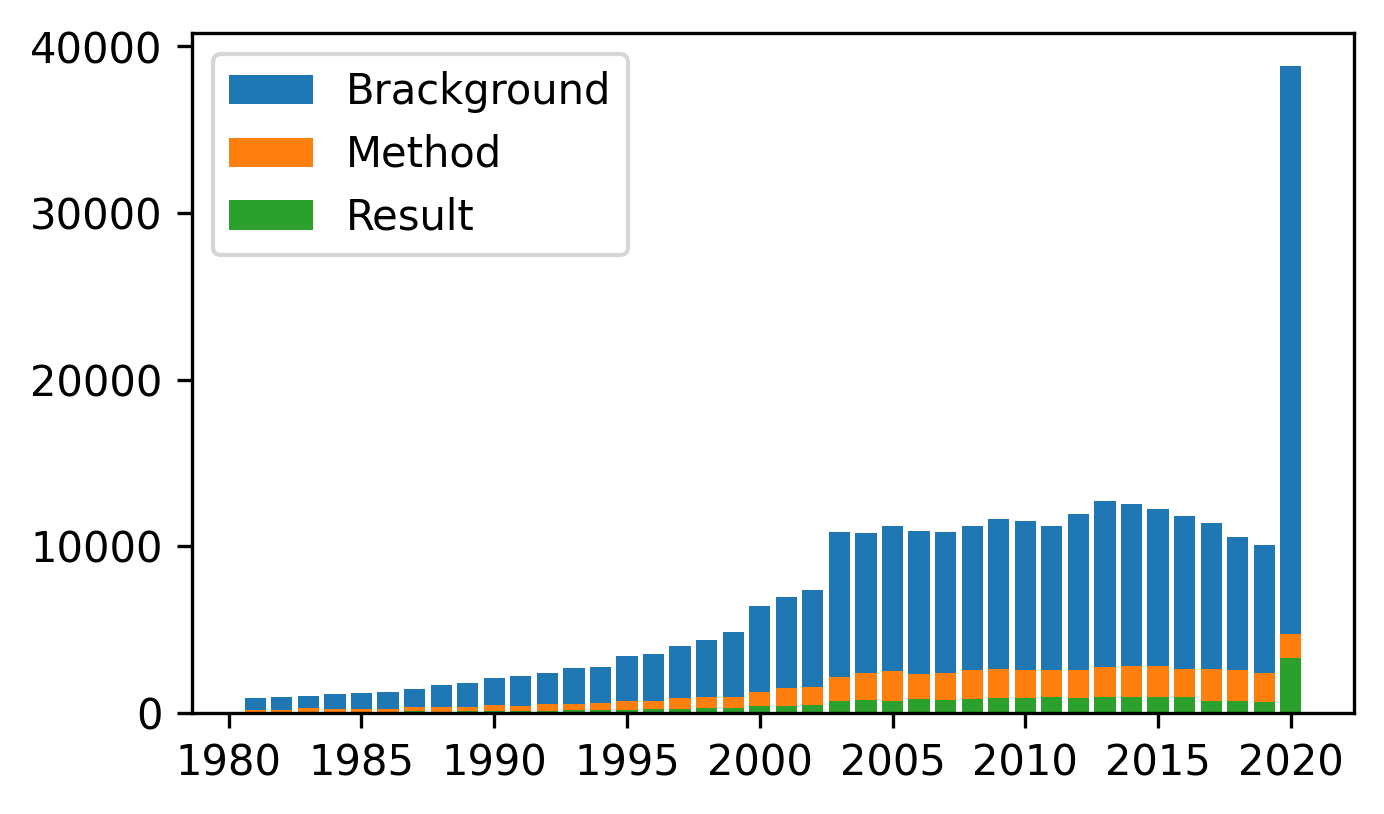

In [22]:
fig = plt.figure(figsize=(5,3), dpi=300)
p1 = plt.bar(bdf["year"].tolist(), bdf["count"].tolist())
p2 = plt.bar(mdf["year"].tolist(), mdf["count"].tolist())
p3 = plt.bar(rdf["year"].tolist(), rdf["count"].tolist())
plt.legend((p1[0], p2[0], p3[0]), ("Brackground", "Method", "Result"))

### Most cited affiliation

In [23]:
cited = defaultdict(int)
citing = defaultdict(int)
self_citing = defaultdict(int)

for i in tqdm(node_affiliation_relations_df.index):
    n1,r,n2 = node_affiliation_relations_df.iloc[i]
    citing[n1] += 1
    cited[n2] += 1
    if n1 == n2:
        self_citing[n1] += 1
        
cited = [[k,v] for k, v in sorted(cited.items(), key=lambda item: item[1], reverse=False)]
citing = [[k,v] for k, v in sorted(citing.items(), key=lambda item: item[1], reverse=False)]
self_citing = [[k,v] for k, v in sorted(self_citing.items(), key=lambda item: item[1], reverse=False)]

cited_df = pd.DataFrame(cited, columns=["affiliation", "count"])
citing_df = pd.DataFrame(citing, columns=["affiliation", "count"])
self_citing_df = pd.DataFrame(self_citing, columns=["affiliation", "count"])

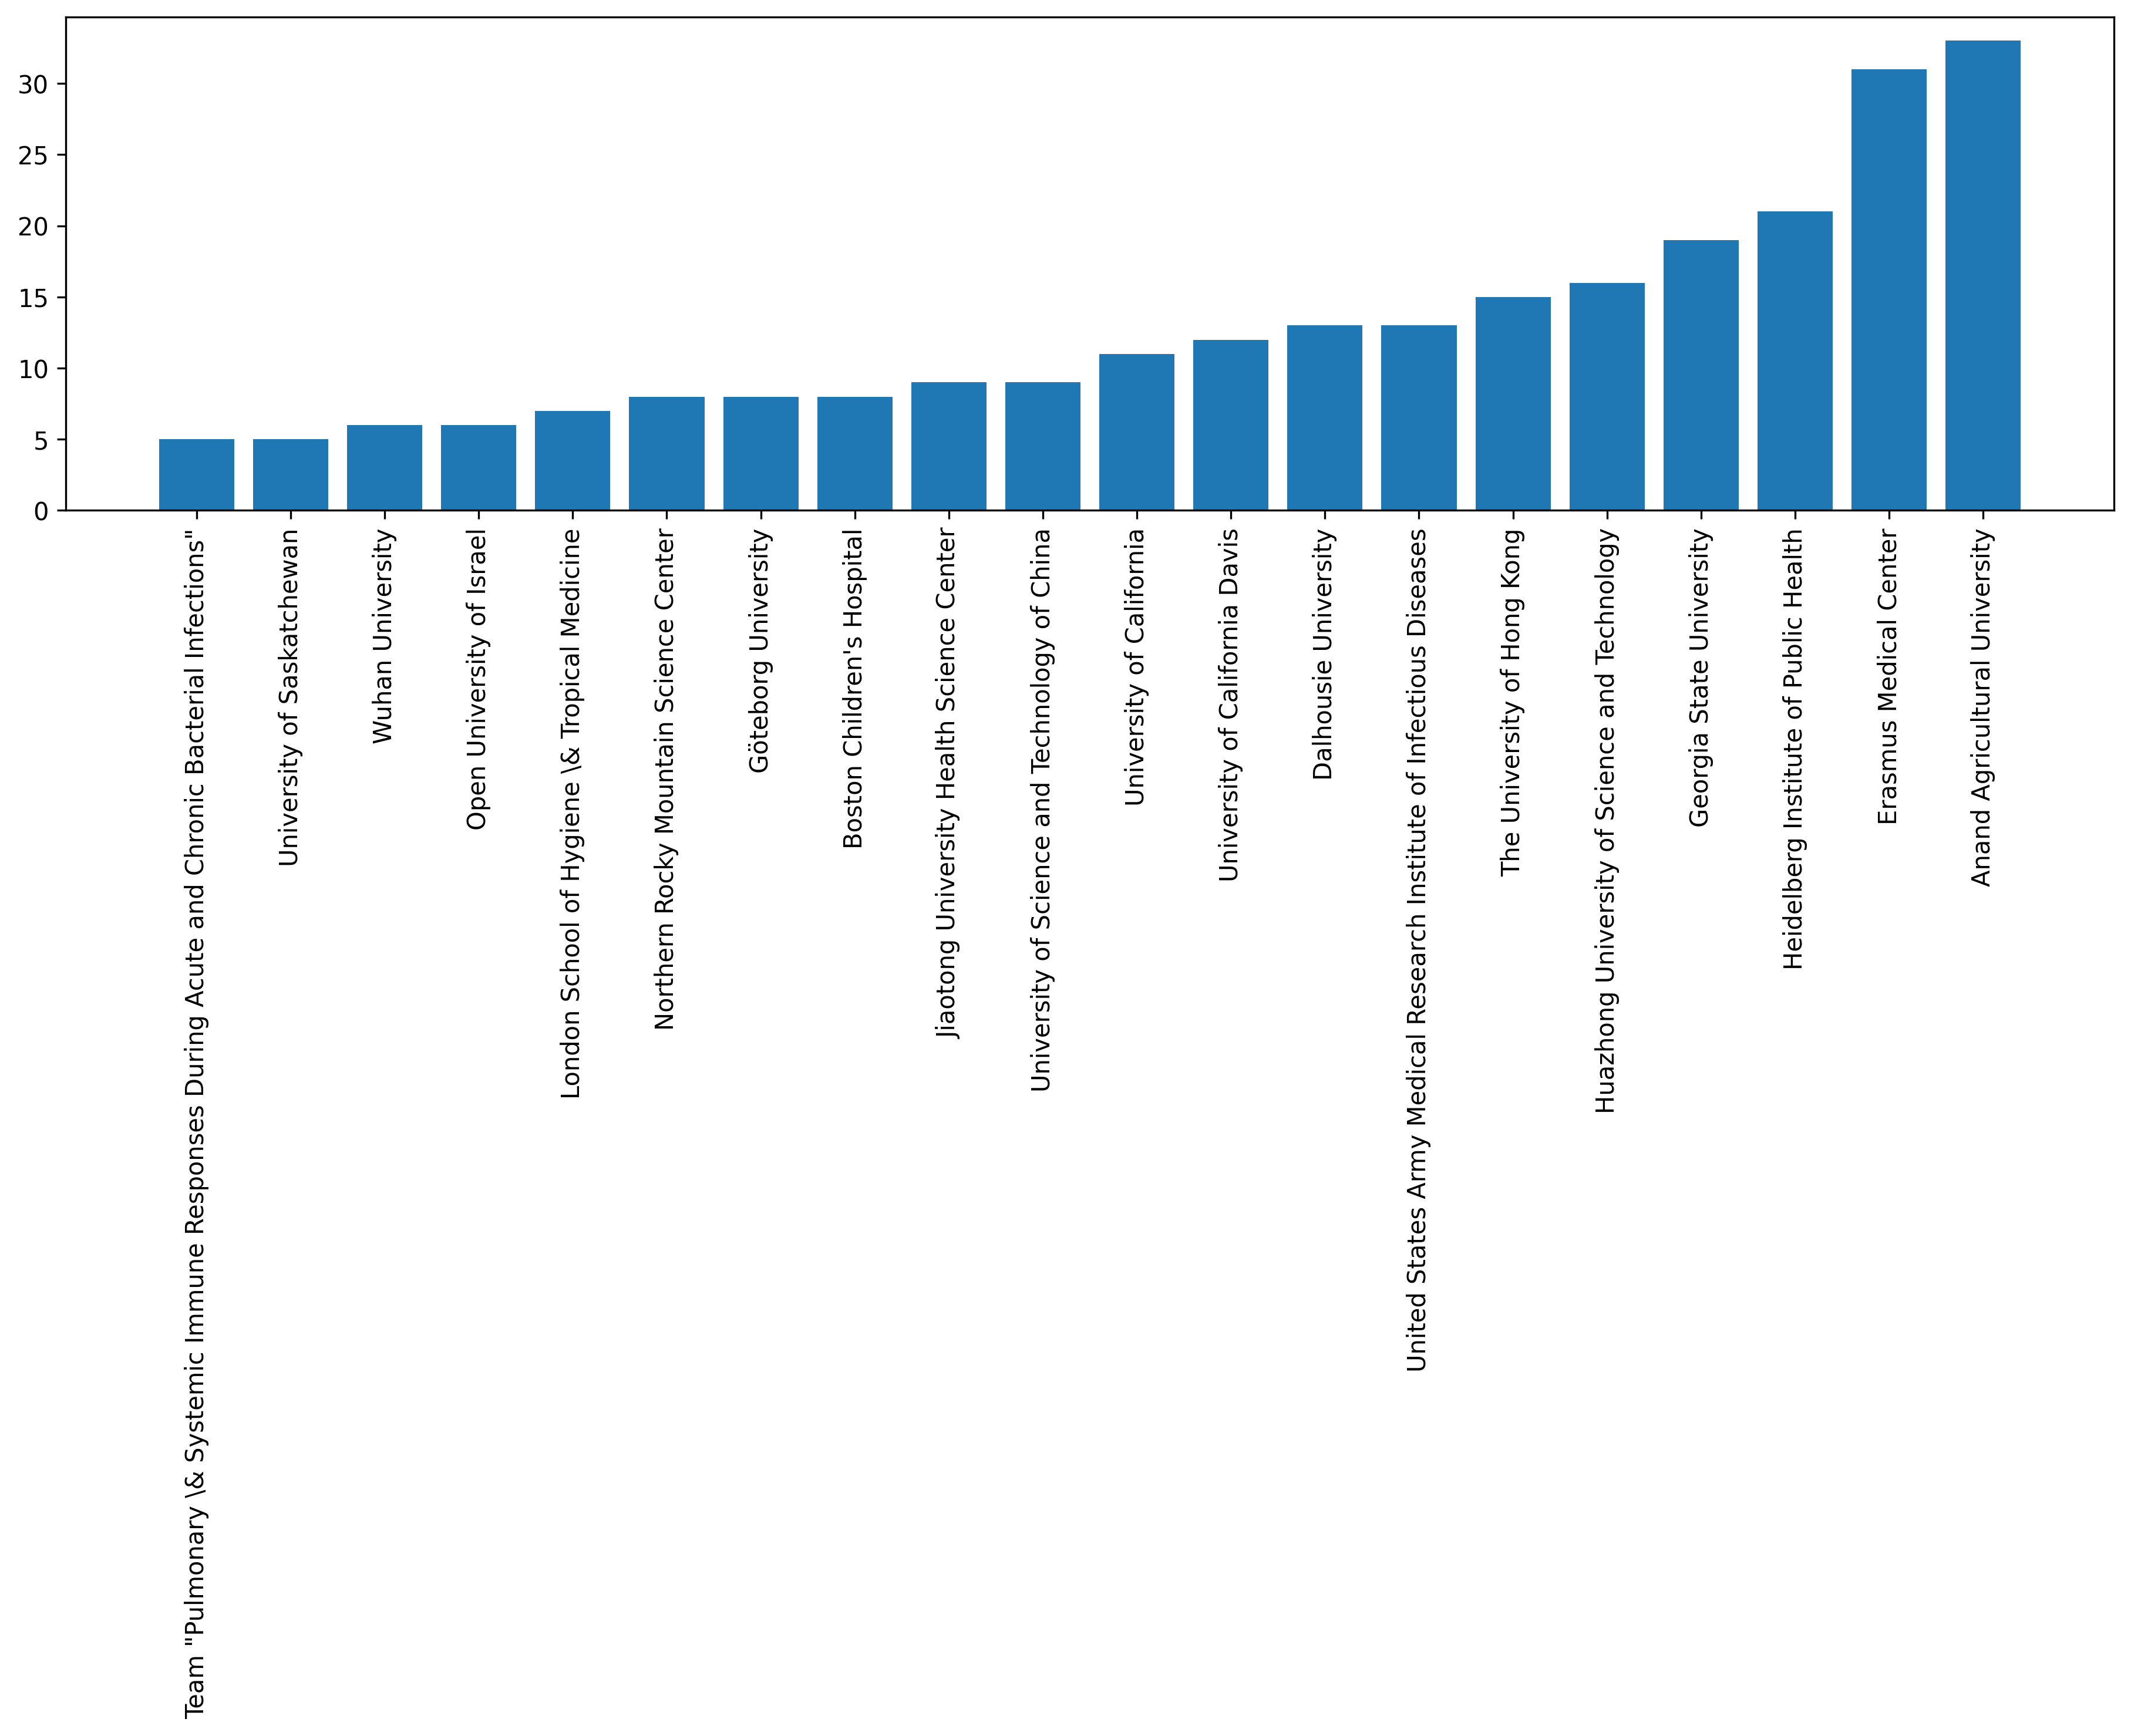

In [24]:
fig = plt.figure(figsize=(15,10), dpi=300)
p1 = plt.bar(cited_df["affiliation"].str.replace("&","\&").tolist()[-20:], cited_df["count"].tolist()[-20:])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.6)
plt.show()

### Most cited affiliation by intent

In [25]:
cited_paper_intent_counts = defaultdict()
citing_paper_intent_counts = defaultdict()

for i in tqdm(node_id_relations_df.index):
    node1, rel, node2, _ = node_id_relations_df.iloc[i]
    
    if node1 in citing_paper_intent_counts:
        citing_paper_intent_counts[node1][rel] = citing_paper_intent_counts[node1][rel]+1
    else:
        citing_paper_intent_counts[node1] = {"Background": 0, "Method": 0, "Result": 0}
        citing_paper_intent_counts[node1][rel] = citing_paper_intent_counts[node1][rel]+1
    
    if node2 in cited_paper_intent_counts:
        cited_paper_intent_counts[node2][rel] = cited_paper_intent_counts[node2][rel]+1
    else:
        cited_paper_intent_counts[node2] = {"Background": 0, "Method": 0, "Result": 0}
        cited_paper_intent_counts[node2][rel] = cited_paper_intent_counts[node2][rel]+1   

In [26]:
cited_i = defaultdict(int)
citing_i = defaultdict(int)
self_citing_i = defaultdict(int)

for i in tqdm(node_affiliation_relations_df.index):
    n1,r,n2 = node_affiliation_relations_df.iloc[i]
    
    if n1 in citing_i:
        citing_i[n1][r] = citing_i[n1][r]+1
    else:
        citing_i[n1] = {"Background": 0, "Method": 0, "Result": 0}
        citing_i[n1][r] = citing_i[n1][r]+1
        
    if n2 in cited_i:
        cited_i[n2][r] = cited_i[n2][r]+1
    else:
        cited_i[n2] = {"Background": 0, "Method": 0, "Result": 0}
        cited_i[n2][r] = cited_i[n2][r]+1
    
    if n1 == n2:
        if n1 in self_citing_i:
            self_citing_i[n1][r] = self_citing_i[n1][r]+1
        else:
            self_citing_i[n1] = {"Background": 0, "Method": 0, "Result": 0}
            self_citing_i[n1][r] = self_citing_i[n1][r]+1

In [27]:
cited_i_b = sorted([[k,v["Background"]] for k, v in cited_i.items()  if v["Background"] > 0], key=lambda item: item[1])
cited_i_m = sorted([[k,v["Method"]] for k, v in cited_i.items() if v["Method"] > 0], key=lambda item: item[1])
cited_i_r = sorted([[k,v["Result"]] for k, v in cited_i.items() if v["Result"] > 0], key=lambda item: item[1])

In [28]:
self_citing_df_i_b = pd.DataFrame(cited_i_b, columns=["affiliation", "count"])
self_citing_df_i_m = pd.DataFrame(cited_i_m, columns=["affiliation", "count"])
self_citing_df_i_r = pd.DataFrame(cited_i_r, columns=["affiliation", "count"])

### Background

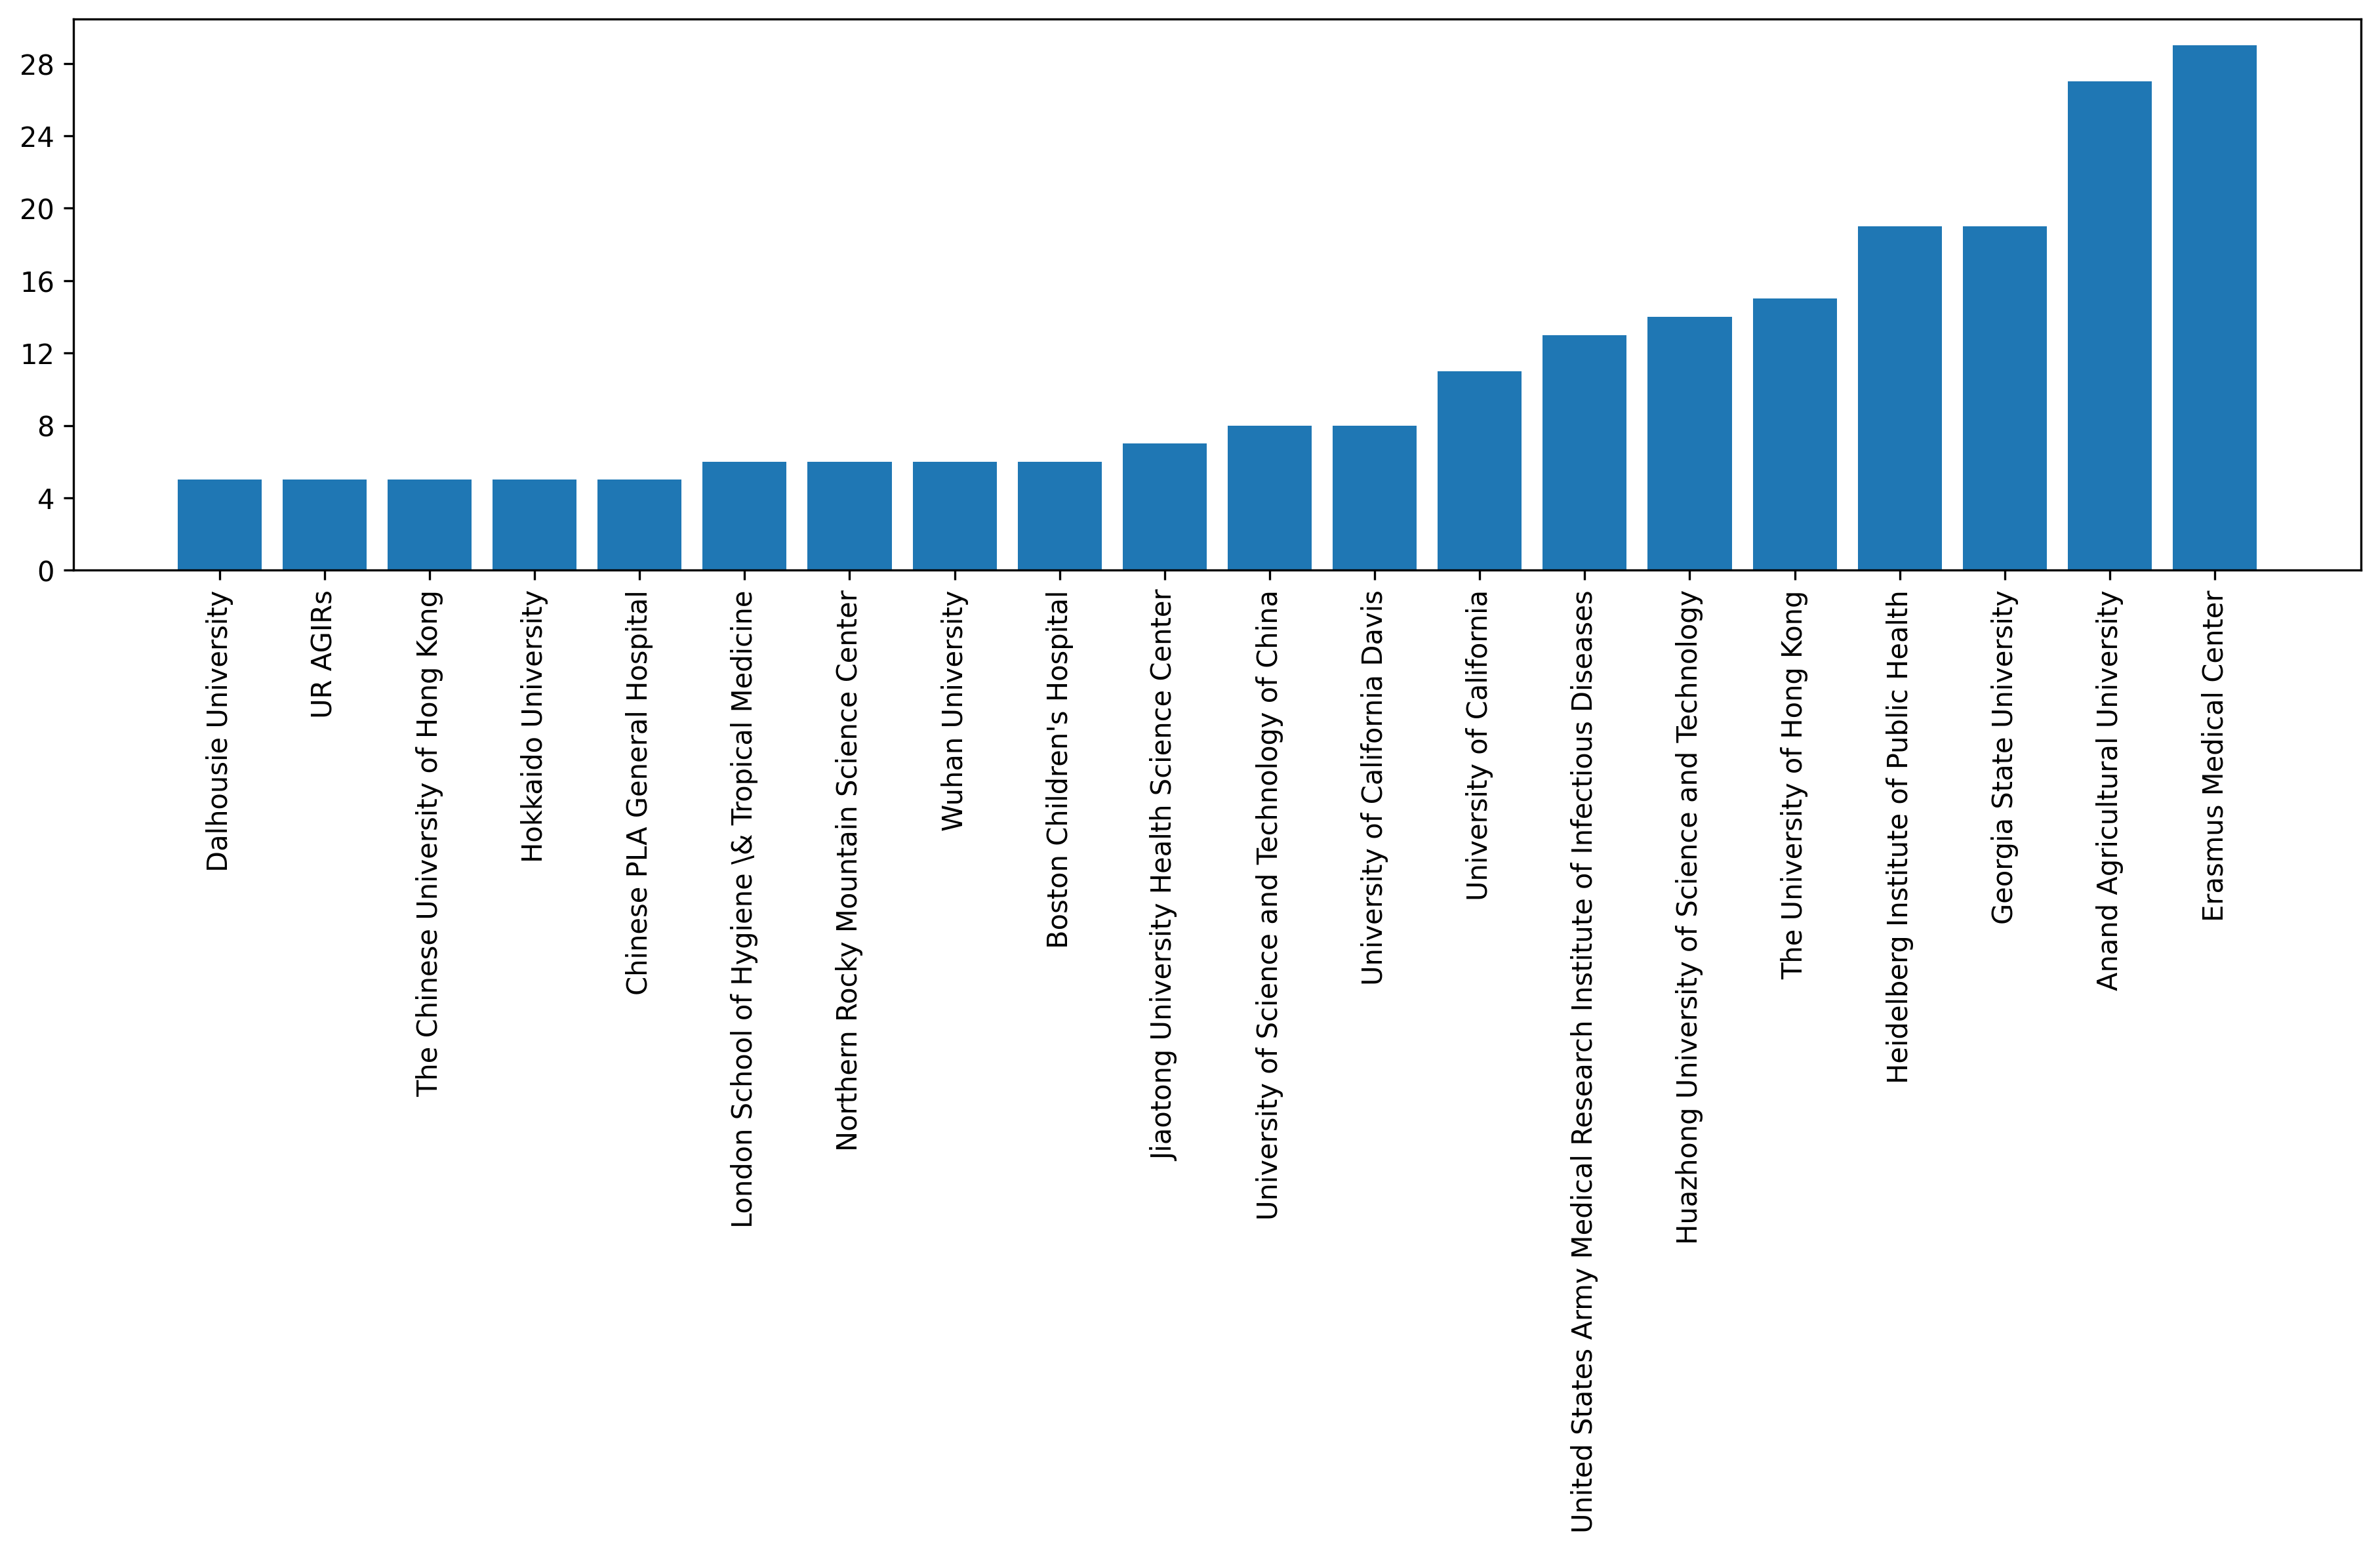

In [29]:
fig = plt.figure(figsize=(15,10), dpi=300)
p1 = plt.bar(self_citing_df_i_b["affiliation"].str.replace("&","\&").tolist()[-20:], self_citing_df_i_b["count"].tolist()[-20:])
ax = fig.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.6)
plt.show()

### Method

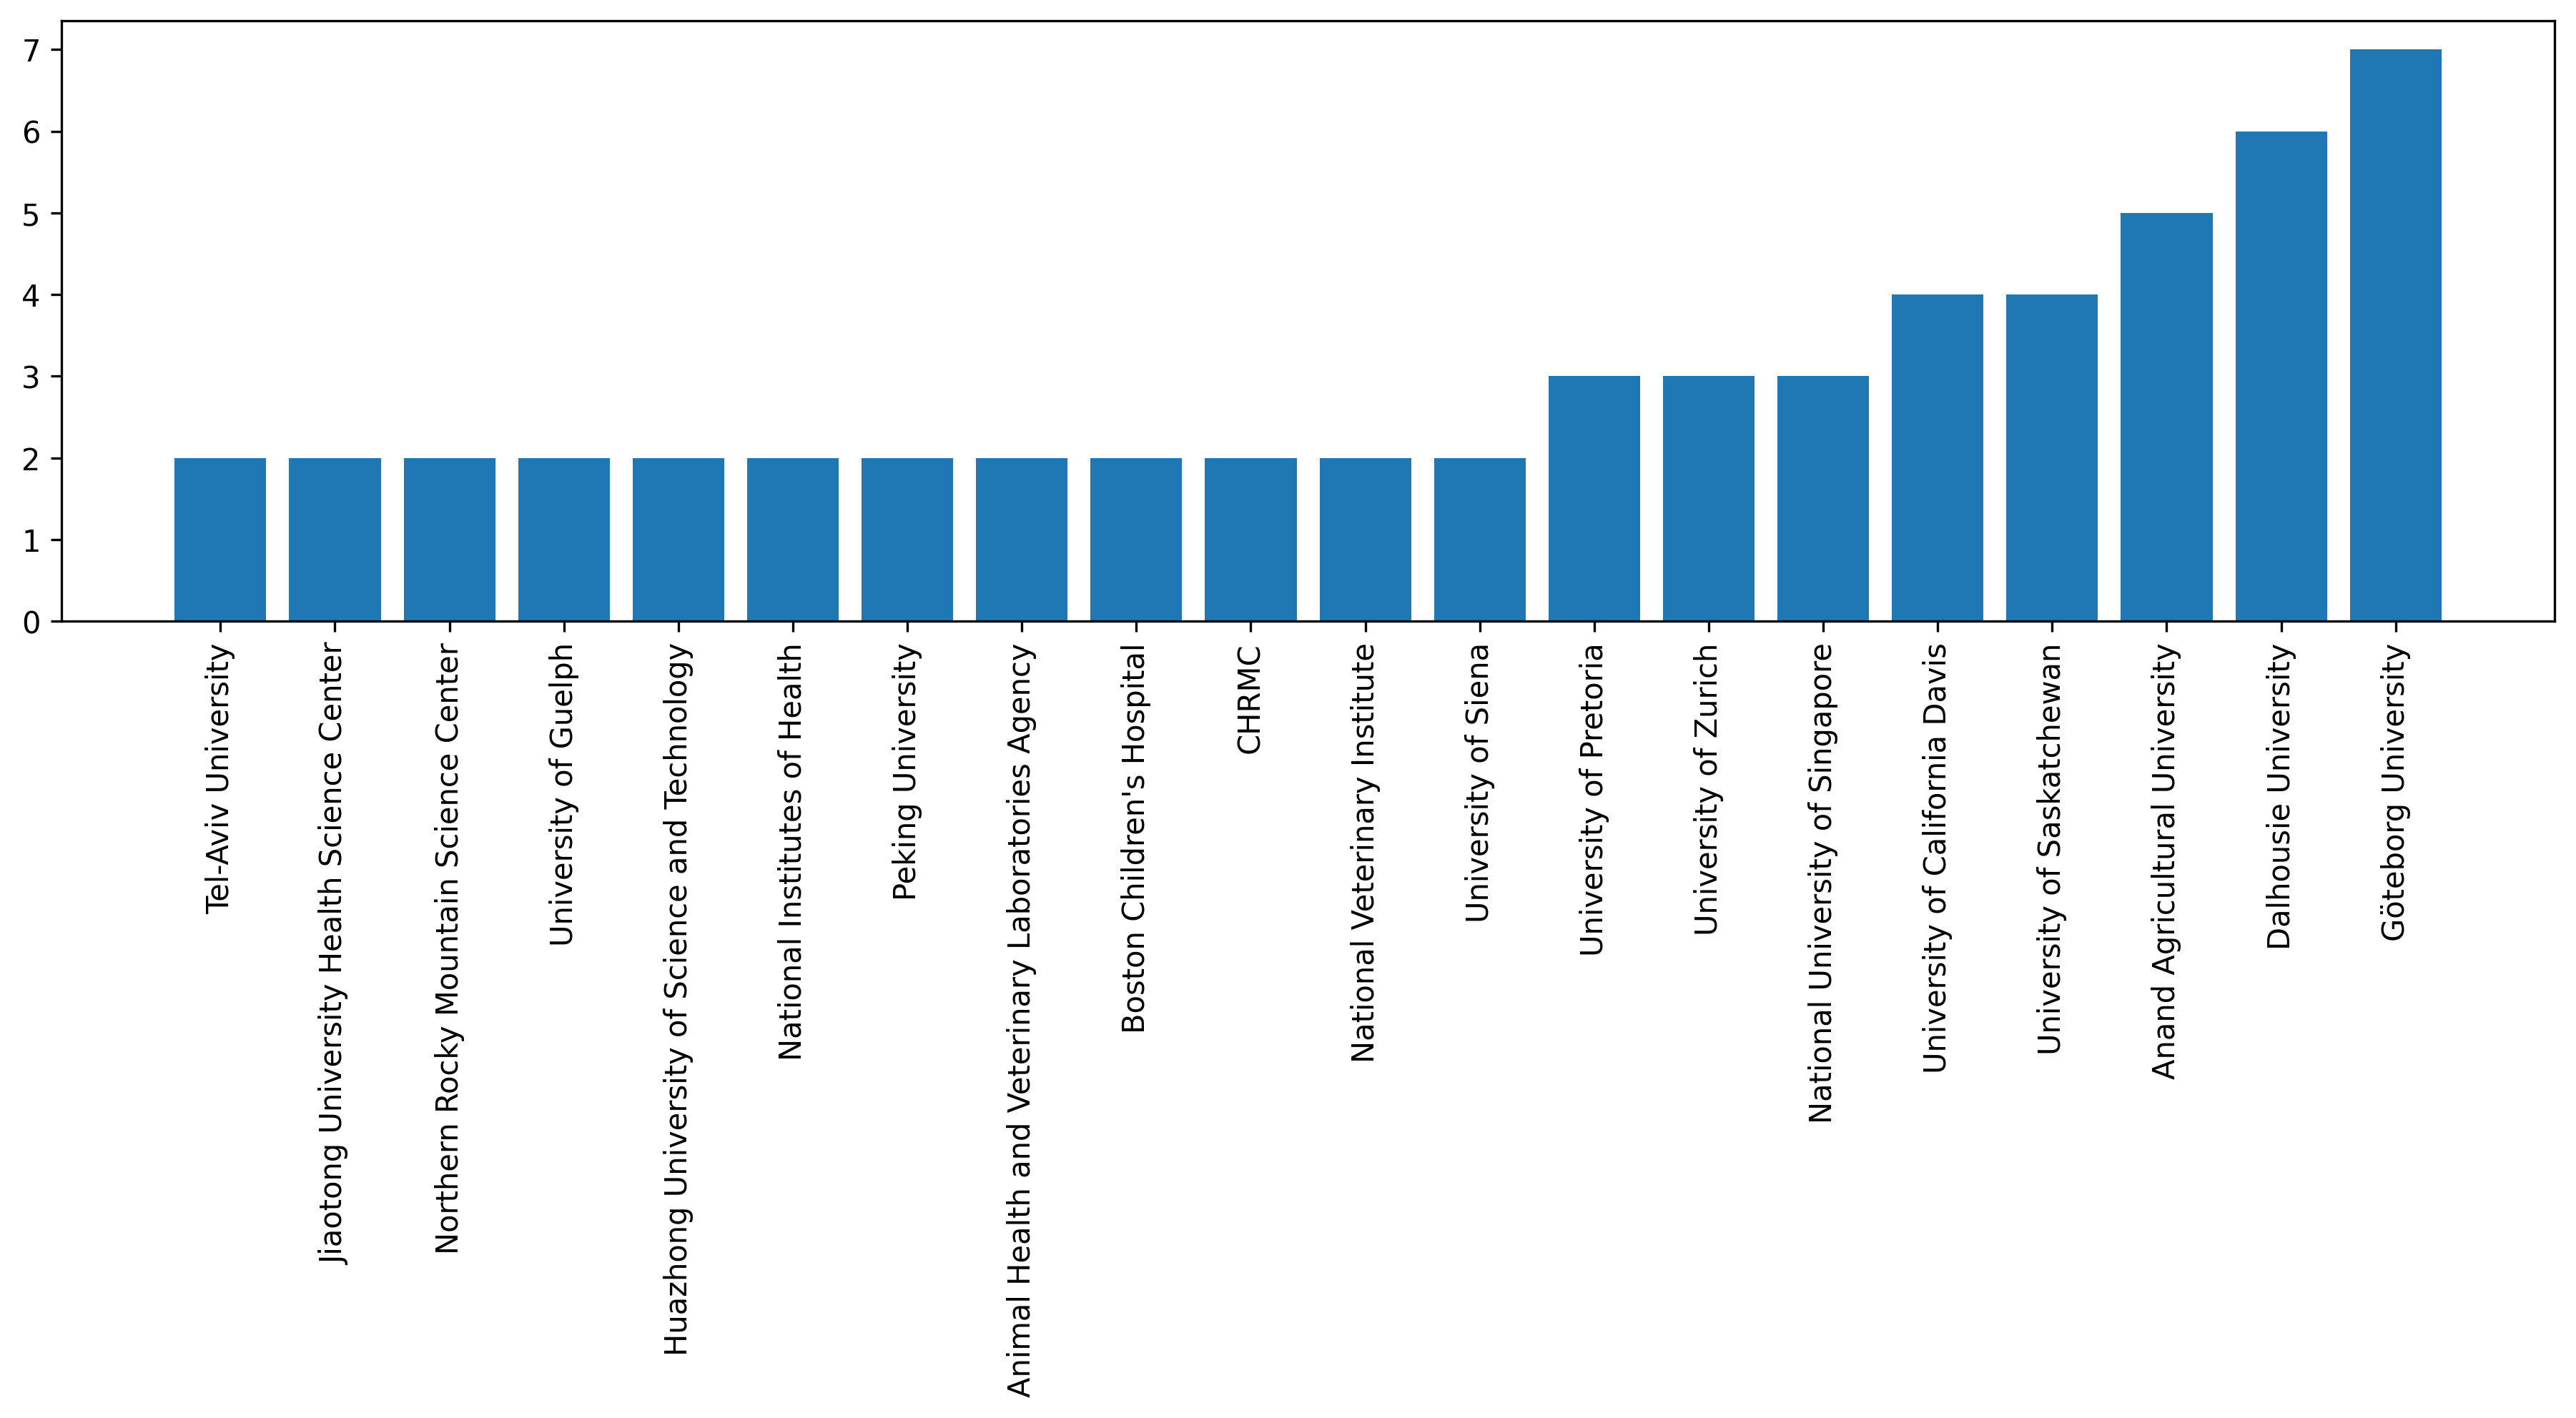

In [30]:
fig = plt.figure(figsize=(15,10), dpi=300)
p1 = plt.bar(self_citing_df_i_m["affiliation"].str.replace("&","\&").tolist()[-20:], self_citing_df_i_m["count"].tolist()[-20:])
ax = fig.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.6)
plt.show()

### Result

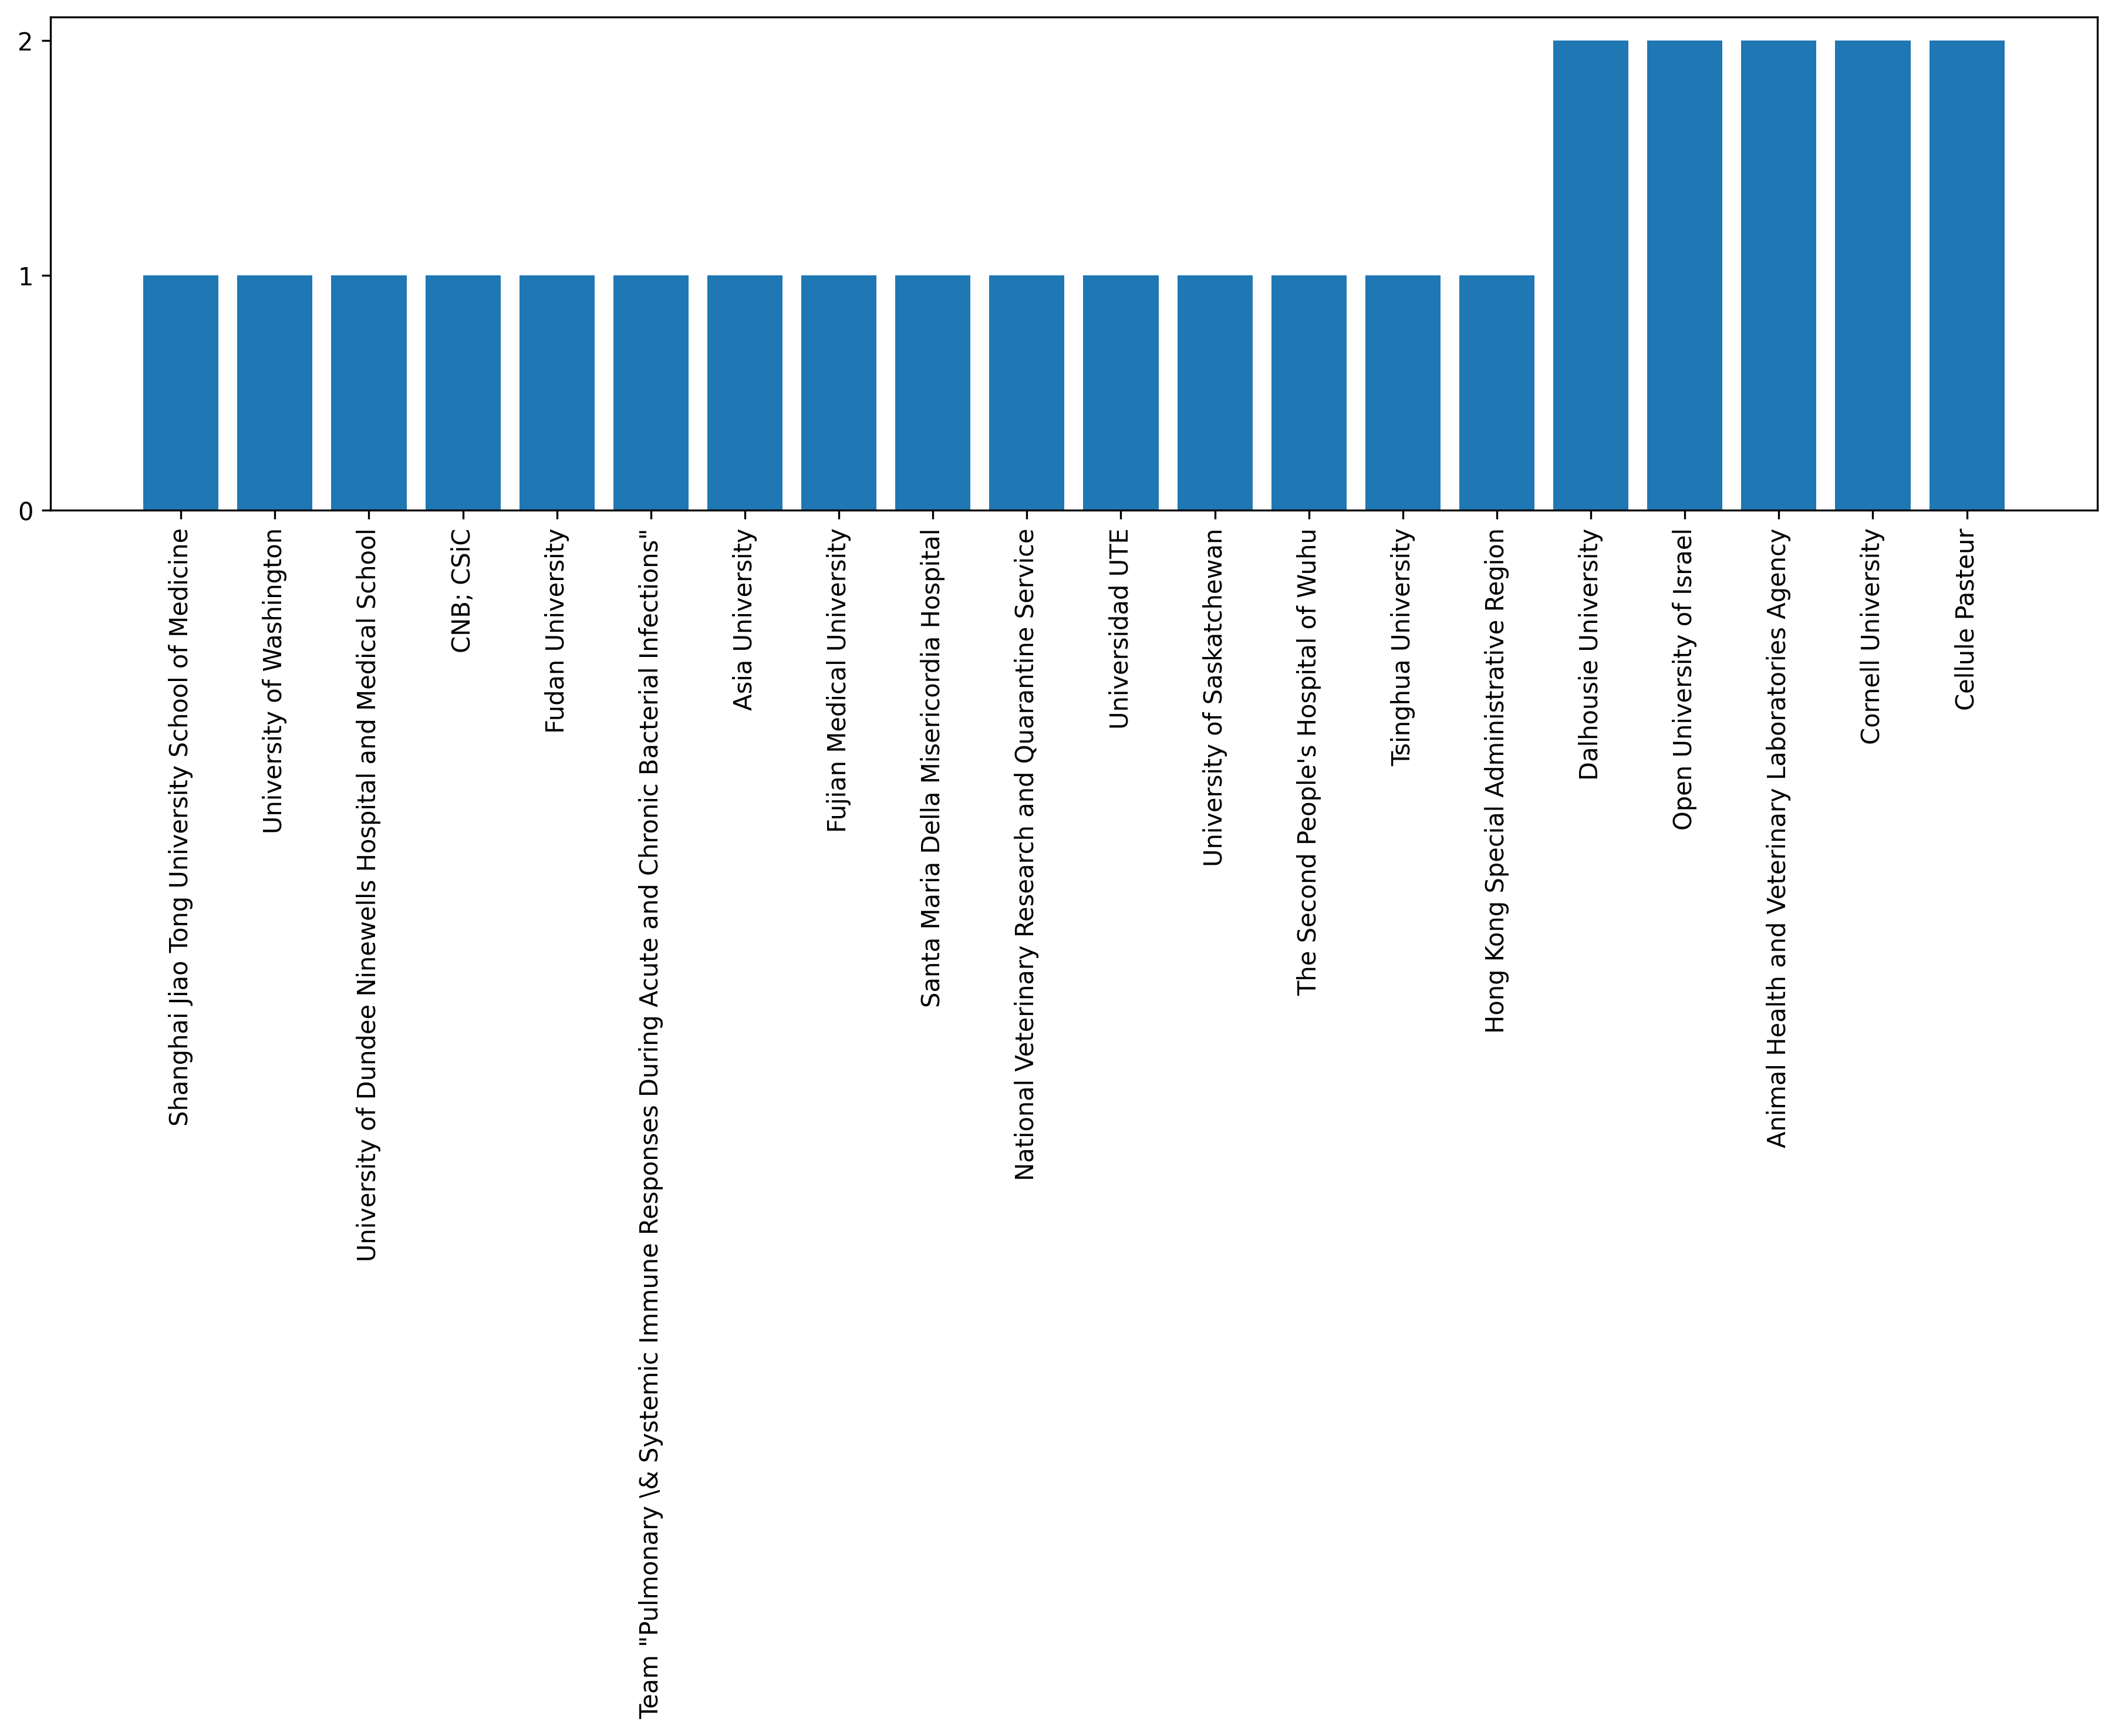

In [31]:
fig = plt.figure(figsize=(15,10), dpi=300)
p1 = plt.bar(self_citing_df_i_r["affiliation"].str.replace("&","\&").tolist()[-20:], self_citing_df_i_r["count"].tolist()[-20:])
ax = fig.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.6)
plt.show()

### Most citing affiliation

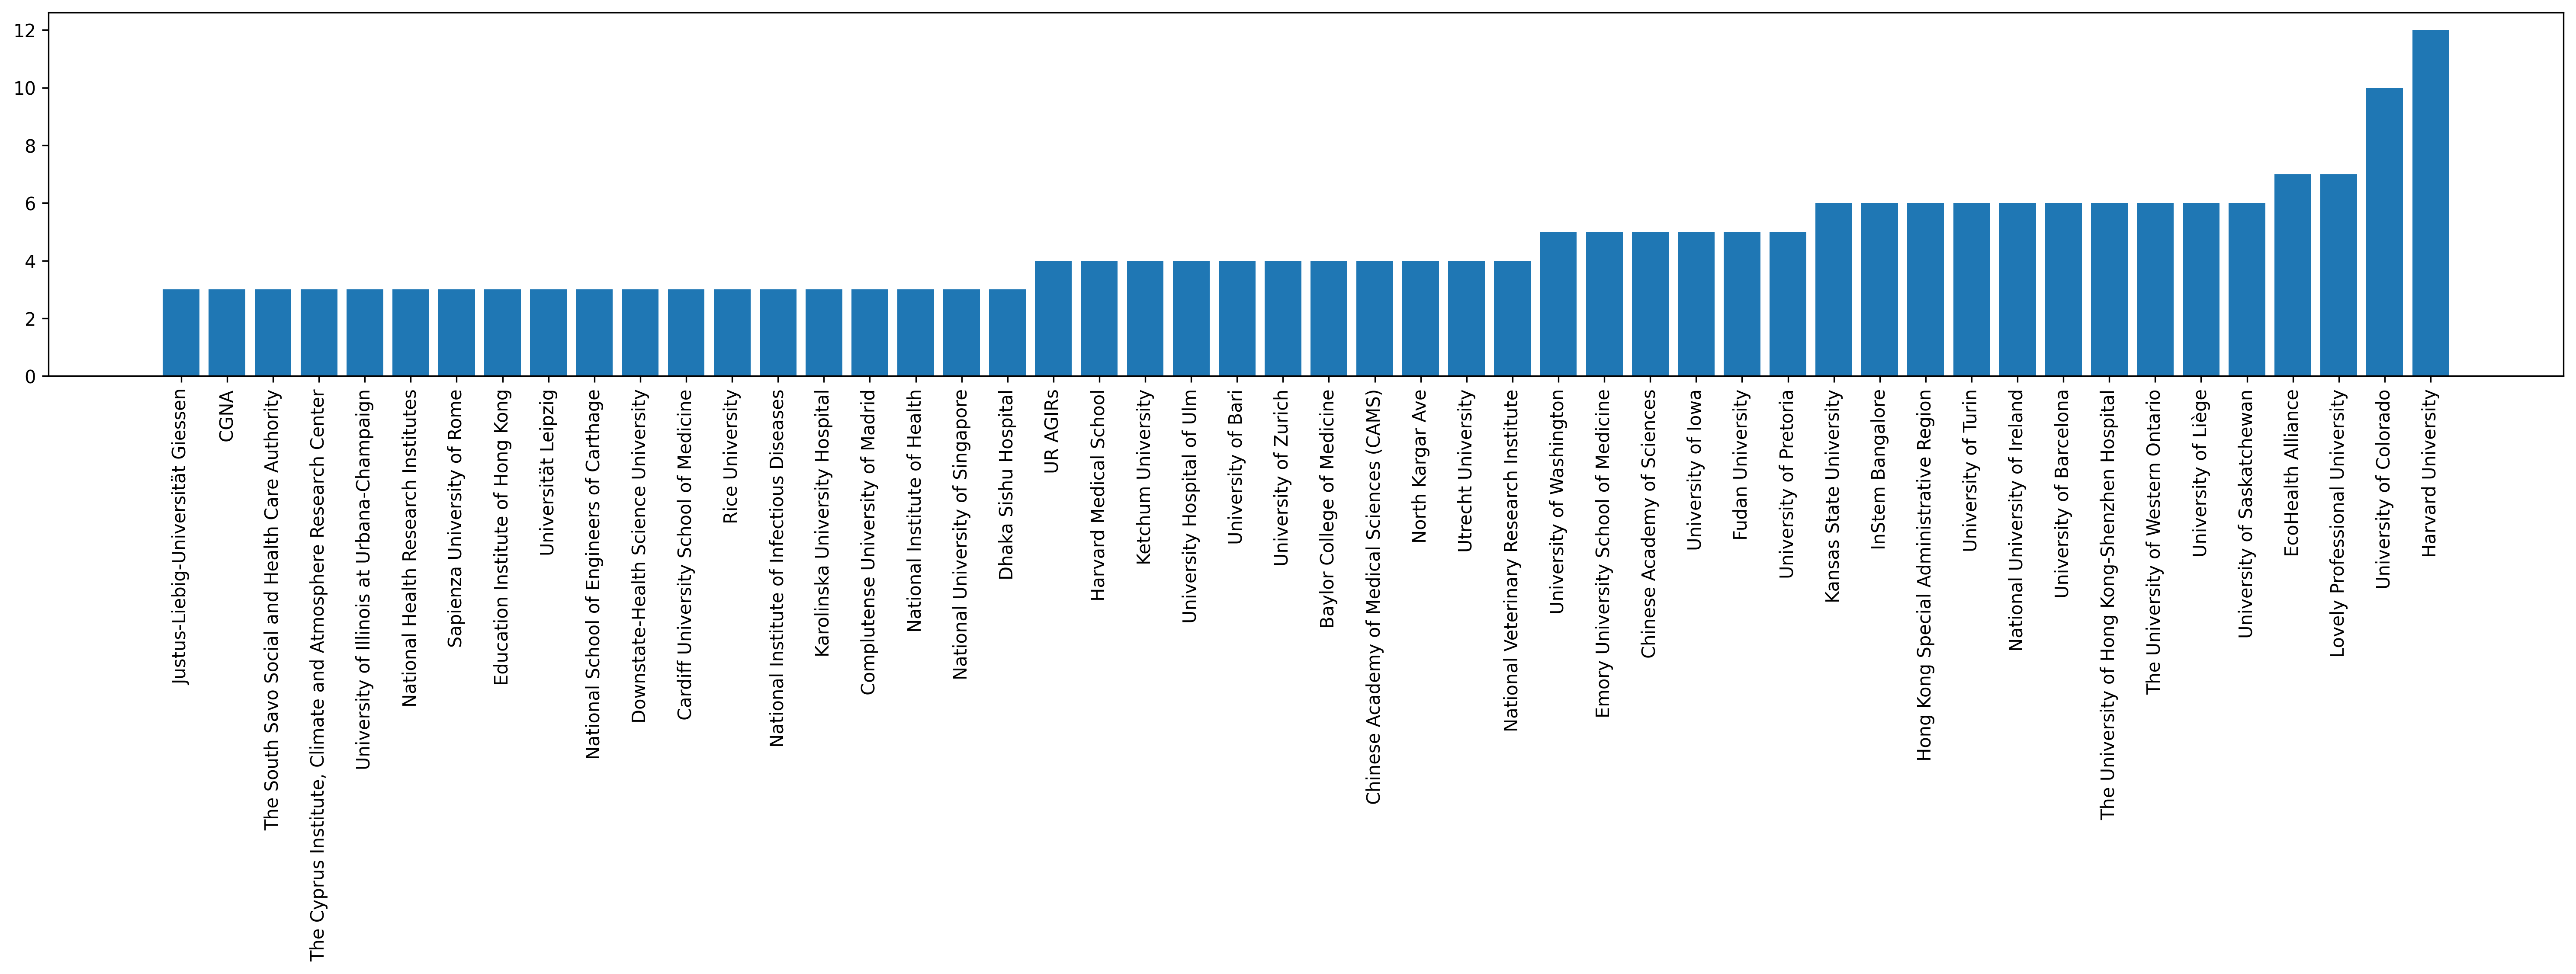

In [32]:
fig = plt.figure(figsize=(25,10), dpi=300)
p1 = plt.bar(citing_df["affiliation"].str.replace("&","\&").tolist()[-50:], citing_df["count"].tolist()[-50:])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.6)
plt.show()

### Most self-citing affiliation

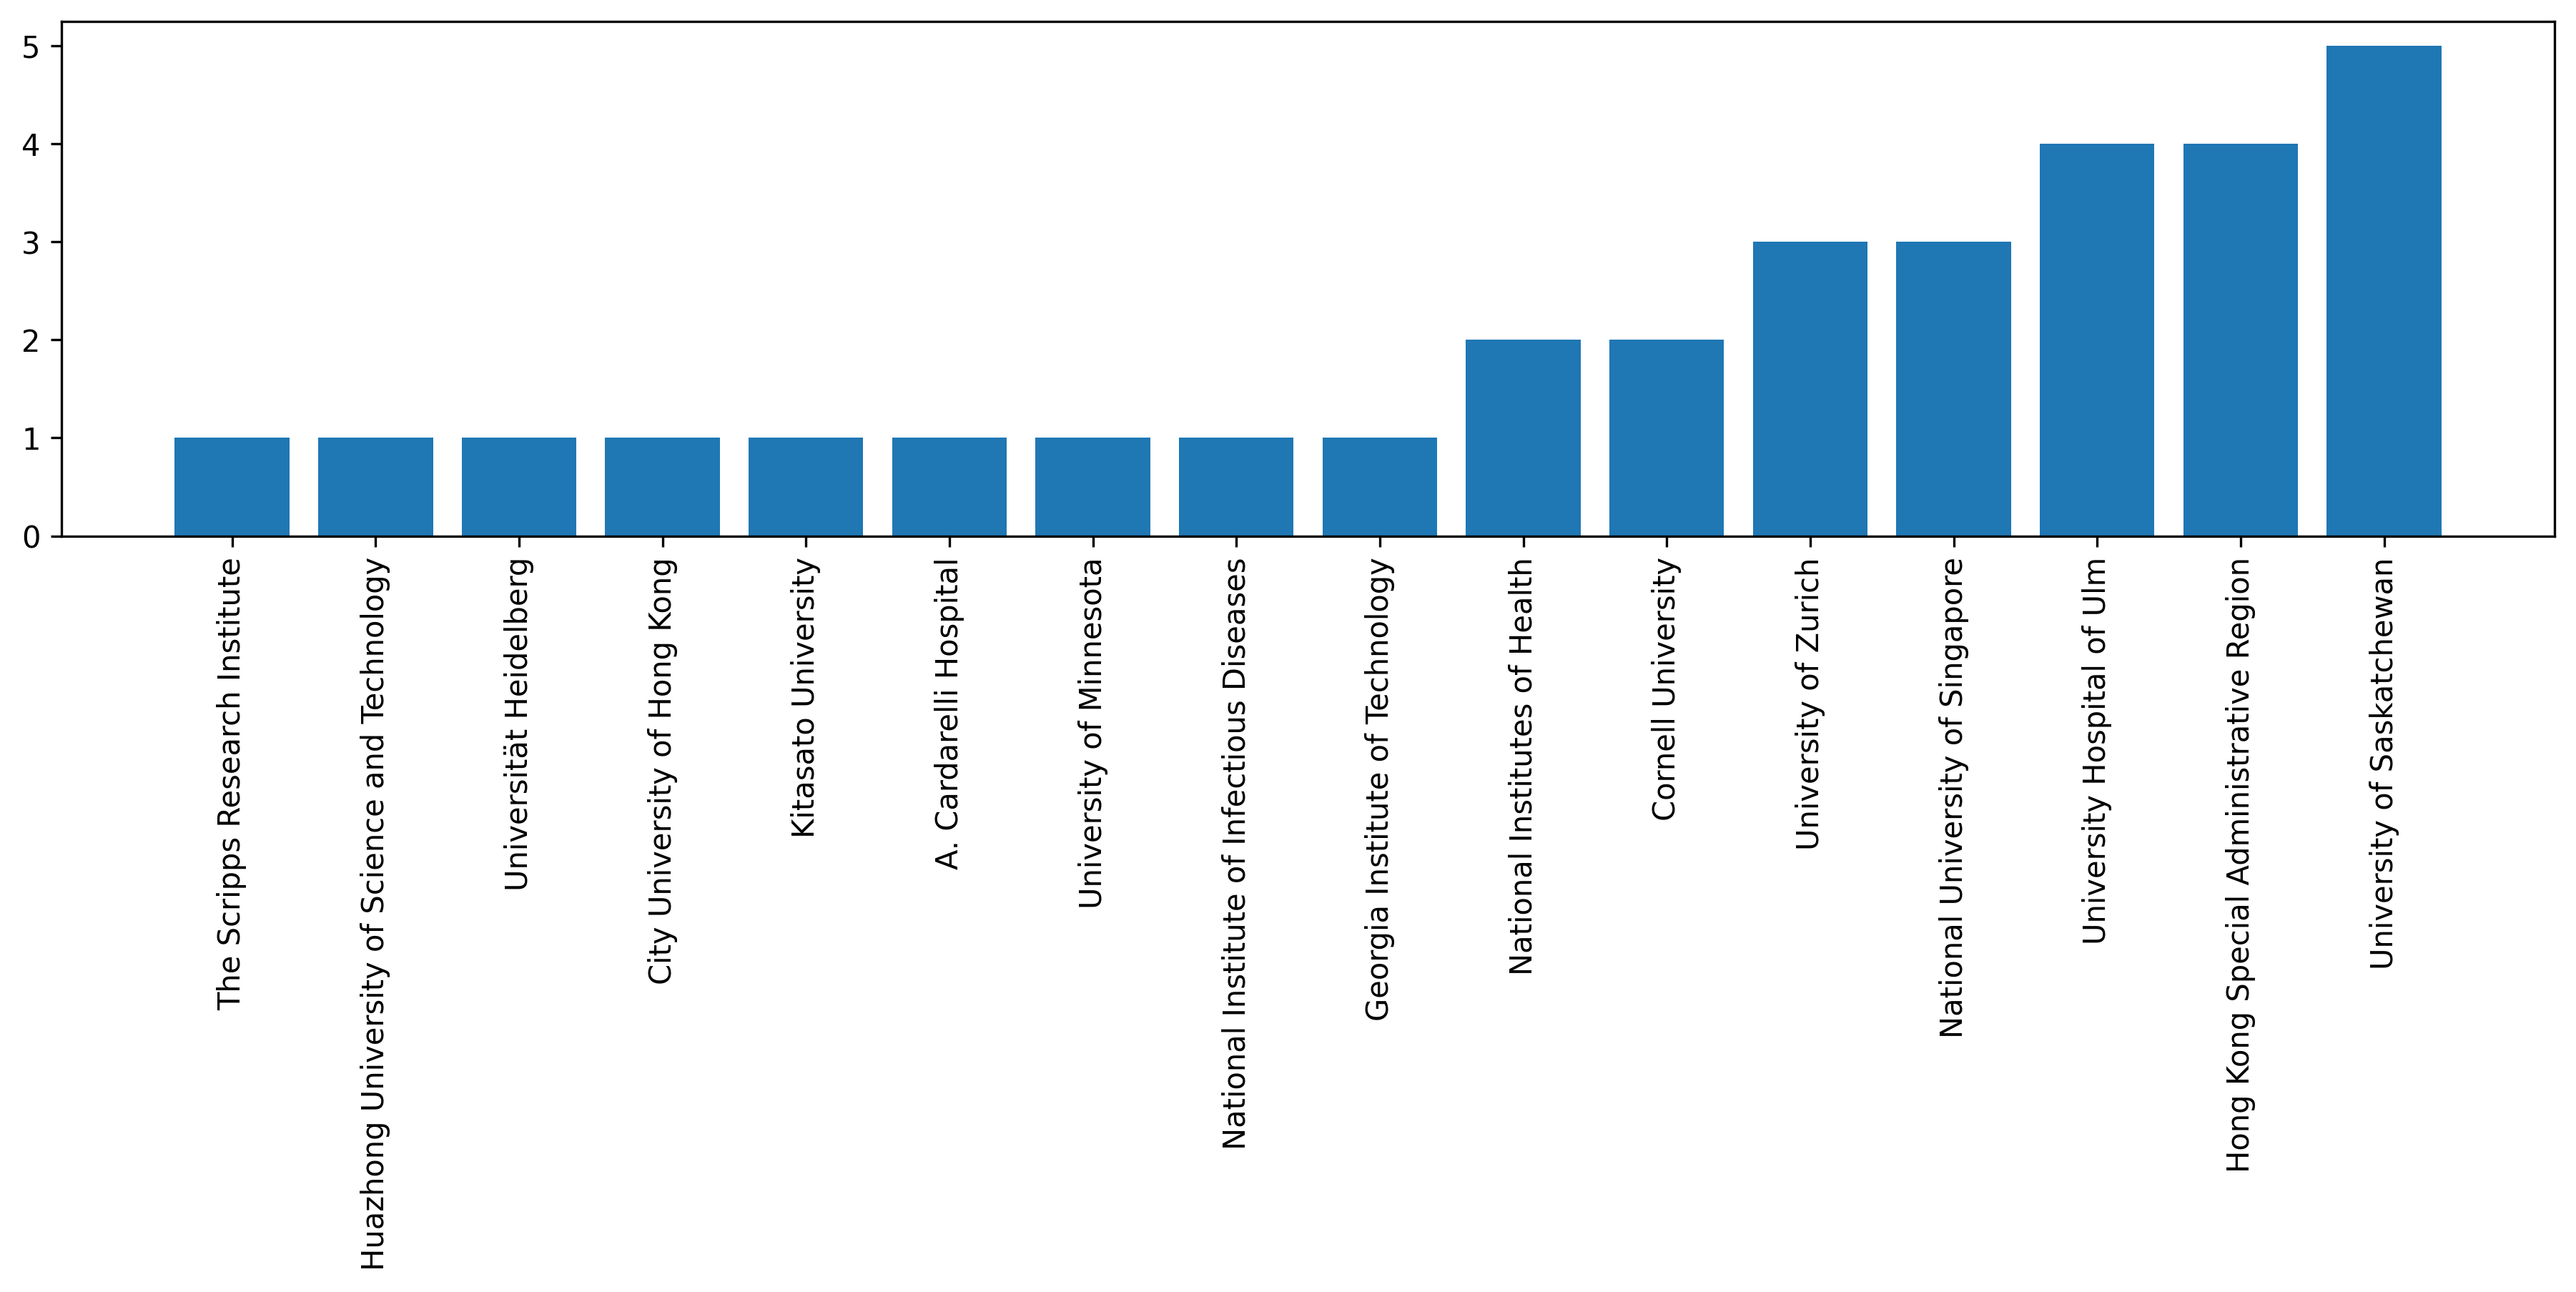

In [33]:
fig = plt.figure(figsize=(15,5), dpi=300)
ax = fig.gca()
p1 = plt.bar(self_citing_df["affiliation"].str.replace("&","\&").tolist()[-50:], self_citing_df["count"].tolist()[-50:])
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(bottom=0.4)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()